<h1>Operationalizing Machine Learning on AWS</h1>

## by 'Femi Bolarinwa

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [1]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
session = sagemaker.Session()
bucket= session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Get the data and copy it to S3</h3>

In [3]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
#!aws s3 cp dogImages s3://udacitysolution/ --recursive

In [7]:
os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg to s3://sagemaker-us-east-1-354600943736/dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg
upload: dogImages/test/001.Affenpi

<h3>Set up parameters, estimator, and tuner</h3>

In [8]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [9]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Fit the tuner</h3>

In [11]:
os.environ['SM_CHANNEL_TRAINING']= "s3://"+ bucket+ "/dogImages/" #'s3://udacitysolution/'
os.environ['SM_MODEL_DIR']= "s3://"+ bucket+ "/model/" #'s3://udacitysolution/model/'
os.environ['SM_OUTPUT_DATA_DIR']= "s3://"+ bucket+ "/output/" #'s3://udacitysolution/output/'
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True) #"s3://udacitysolution/"})

Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [13]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-231212-1841')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""256""",0.003422,pytorch-training-231212-1841-002-c47c0e78,Completed,419.0,2023-12-12 19:05:51+00:00,2023-12-12 19:25:38+00:00,1187.0
1,"""32""",0.004099,pytorch-training-231212-1841-001-2e4e5b2a,Completed,61.0,2023-12-12 18:42:31+00:00,2023-12-12 19:02:53+00:00,1222.0


## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [14]:
best_estimator=tuner.best_estimator()


2023-12-12 19:05:49 Starting - Preparing the instances for training
2023-12-12 19:05:49 Downloading - Downloading input data
2023-12-12 19:05:49 Training - Training image download completed. Training in progress.
2023-12-12 19:05:49 Uploading - Uploading generated training model
2023-12-12 19:05:49 Completed - Resource reused by training job: pytorch-training-231212-1841-002-c47c0e78


In [15]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.004099256305098328',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-12-12-18-41-00-193"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-354600943736/pytorch_dog_hpo-2023-12-12-18-41-00-193/source/sourcedir.tar.gz"'}

In [16]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.004099256305098328'}

In [17]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [18]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [19]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [21]:
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-12-12-19-29-43-987


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [48]:
###in this cell, create and fit an estimator using multi-instance training

estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-12-12-20-53-16-554


Using provided s3_resource


<h2>Deployment</h2>

In [49]:
model_location=estimator.model_data


In [24]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [25]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [50]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [51]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-354600943736/dog-pytorch-2023-12-12-20-53-16-554/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-354600943736/pytorch-inference-2023-12-12-21-19-32-586/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-12-12-21-19-45-686
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-12-12-21-19-46-379
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-12-12-21-19-46-379


-----!

In [28]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

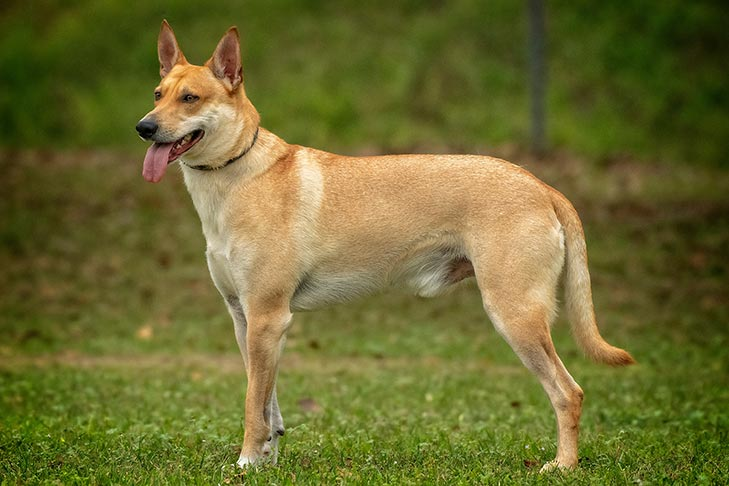

In [29]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [52]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [53]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [54]:
type(response2[0][0])

float

In [55]:
response2[0]

[-17.59284019470215,
 -9.236837387084961,
 -7.067824363708496,
 -4.12099027633667,
 -4.433526039123535,
 -14.484598159790039,
 -2.1540544033050537,
 -3.322157382965088,
 -12.38521957397461,
 -6.4254374504089355,
 -1.6744301319122314,
 -6.694097518920898,
 -5.838618278503418,
 -2.5299124717712402,
 -6.133054256439209,
 -4.222506523132324,
 -11.276371002197266,
 -3.184203863143921,
 -9.03726577758789,
 -3.316030740737915,
 -10.314987182617188,
 -5.746061325073242,
 -6.846641540527344,
 -9.6603364944458,
 -5.566239833831787,
 -11.959568977355957,
 -5.252140045166016,
 -4.744714260101318,
 -8.224257469177246,
 -3.331678628921509,
 -4.128255367279053,
 -6.471146106719971,
 -16.514236450195312,
 -6.342918872833252,
 -12.50295639038086,
 -14.9061861038208,
 -4.744229316711426,
 -7.763582706451416,
 -4.003729820251465,
 -9.714716911315918,
 -8.636046409606934,
 -10.69703483581543,
 -2.8951642513275146,
 -7.222990036010742,
 -3.753579616546631,
 -9.864822387695312,
 -6.309525489807129,
 -5.6406

In [56]:
import torch
import numpy as np
np.argmax(response, 1)

array([10])

In [ ]:
#enpoint 1 prediction = 80
#endpoint 2 prediction = 42
#endpoint 3 prediction = 10

#lambda test result
#"body": "[[-17.59284019470215, -9.236837387084961, -7.067824363708496, -4.12099027633667, -4.433526039123535, -14.484598159790039, -2.1540544033050537, -3.322157382965088, -12.38521957397461, -6.4254374504089355, -1.6744301319122314, -6.694097518920898, -5.838618278503418, -2.5299124717712402, -6.133054256439209, -4.222506523132324, -11.276371002197266, -3.184203863143921, -9.03726577758789, -3.316030740737915, -10.314987182617188, -5.746061325073242, -6.846641540527344, -9.6603364944458, -5.566239833831787, -11.959568977355957, -5.252140045166016, -4.744714260101318, -8.224257469177246, -3.331678628921509, -4.128255367279053, -6.471146106719971, -16.514236450195312, -6.342918872833252, -12.50295639038086, -14.9061861038208, -4.744229316711426, -7.763582706451416, -4.003729820251465, -9.714716911315918, -8.636046409606934, -10.69703483581543, -2.8951642513275146, -7.222990036010742, -3.753579616546631, -9.864822387695312, -6.309525489807129, -5.640625476837158, -5.954952239990234, -7.5314717292785645, -6.2659912109375, -9.554998397827148, -9.487929344177246, -6.337060928344727, -8.740092277526855, -2.4235095977783203, -8.197415351867676, -9.820588111877441, -3.2530739307403564, -7.93742036819458, -8.426139831542969, -7.673404216766357, -8.364325523376465, -9.917014122009277, -2.759237051010132, -13.528987884521484, -3.448087215423584, -8.416460990905762, -5.963663101196289, -4.425930023193359, -2.4709019660949707, -9.11512565612793, -8.42821979522705, -13.37205696105957, -10.515690803527832, -6.712928771972656, -9.36296558380127, -4.844581127166748, -10.398797988891602, -4.186346054077148, -2.8527112007141113, -13.446145057678223, -2.748706817626953, -5.597010612487793, -7.841383934020996, -9.355940818786621, -7.453980445861816, -9.9771089553833, -10.018013000488281, -4.597062110900879, -11.632560729980469, -15.885757446289062, -8.702770233154297, -14.304637908935547, -8.501331329345703, -5.489809036254883, -8.391162872314453, -8.87529182434082, -9.638789176940918, -11.9279203414917, -13.816865921020508, -4.794556617736816, -8.37659740447998, -8.259385108947754, -11.568593978881836, -11.298644065856934, -6.602653980255127, -4.13091516494751, -6.654895782470703, -4.33683967590332, -5.436748027801514, -5.037302494049072, -13.063488006591797, -10.894684791564941, -13.723236083984375, -4.799492835998535, -10.880433082580566, -4.0635666847229, -8.79650592803955, -4.124069690704346, -5.542270660400391, -3.8566808700561523, -12.335667610168457, -6.350172519683838, -14.653563499450684, -7.828548431396484, -7.16109561920166, -2.901899576187134, -6.048239707946777, -5.66408109664917, -13.537166595458984, -4.438143730163574, -10.689398765563965]]"
